Initial version forked from SCTP-working(LGB) https://www.kaggle.com/dromosys/sctp-working-lgb courtesy of Dromosys

# How can we genetically engineer features?

## Executive Summary
We would like to find a mathematical formula that will create a new feature from the ones we have - and therefore give the machine learning algorithms more to work with. In the case of the Santander competition, this is dificult because the features are already well pre-processed. In other words, they are already statistically independent and seem to contain little, if any, redundant information (as if principal component analysis has already been performed). Instead, we can turn to generically engineered formulas to create new features. 


Specificaly, if we use 199 of the 200 features to create an estimation of the missing feature - this will be a imperfect estimation, because as noted above, the features do not contain redundant information. Nevertheless, this poor estimation can be considered to be a "new feature" or a new classification of the current 199 features as being a member of the missing feature target. This can be repeated for every feature, giving us 200 new features to add to the training (and testing) sets.

This kernel demonstrates this, and uses "gplearn" which extends the scikit-learn machine learning library to perform Genetic Programming (GP) with symbolic regression.

## Background
From the website https://gplearn.readthedocs.io/en/stable/intro.html ...

"Symbolic regression is a machine learning technique that aims to identify an underlying mathematical expression that best describes a relationship. It begins by building a population of naive random formulas to represent a relationship between known independent variables and their dependent variable targets in order to predict new data. Each successive generation of programs is then evolved from the one that came before it by selecting the fittest individuals from the population to undergo genetic operations."


In [1]:
# INPORTING WHAT WE NEED
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import os
import time
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV

# GENETIC ALGORITHM
import gplearn
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

In [2]:
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [3]:
train_df = pd.read_csv('../input/train.csv')
print('Rows: ',train_df.shape[0],'Columns: ',train_df.shape[1])
train_df.info()

Rows:  200000 Columns:  202
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
train_df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

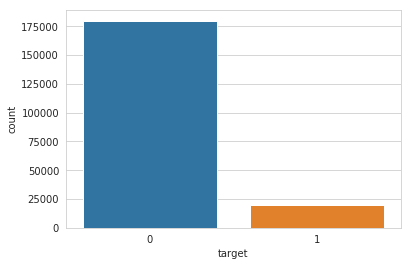

In [6]:
sns.countplot(train_df['target'])
sns.set_style('whitegrid')

In [7]:
test_df = pd.read_csv('../input/test.csv')

In [8]:
X_test1 = test_df.drop('ID_code',axis=1)

In [9]:
X1 = train_df.drop(['ID_code','target'],axis=1)

In [10]:
# Create a fitness function that is the mean absolute percentage error
def _my_fit(y, y_pred, w):
    diffs = np.abs(y - y_pred)  
    return 100. * np.average(diffs, weights=w)
my_fit = make_fitness(_my_fit, greater_is_better=False)

In [11]:
# Choose the mathematical functions we will combine together
function_set = ['add', 'sub', 'mul', 'div', 'log', 
                'sqrt', 'log', 'abs', 'neg', 'inv', 
                'max', 'min', 
                'sin', 'cos', 'tan' ] 

# Create the genetic learning regressor
gp = SymbolicRegressor(function_set=function_set, metric = my_fit,
                       verbose=1, generations = 3, 
                       random_state=0, n_jobs=-1)


In [12]:
# Using NUMPY structures, remove one feature (column of data) at a time from the training set
# Use that removed column as the target for the algorithm
# Use the genetically engineered formula to create the new feature
# Do this for both the training set and the test set

X1a = np.array(X1)
sam = X1a.shape[0]
col = X1a.shape[1]
X2a = np.zeros((sam, col))

X_test1a = np.array(X_test1)
sam_test = X_test1a.shape[0]
col_test = X_test1a.shape[1]
X_test2a = np.zeros((sam_test, col_test))

for i in range(col) :
    X = np.delete(X1a,i,1)
    y = X1a[:,i]
    gp.fit(X, y) 
    X2a[:,i] = gp.predict(X)
    X = np.delete(X_test1a, i, 1)
    X_test2a[:,i] = gp.predict(X)
    
X2 = pd.DataFrame(X2a)
X_test2 = pd.DataFrame(X_test2a) 

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.91 2651.5255094758927        3     258.29207545              N/A     25.20s
   1     4.08 642.2772833243322        3 252.73222350000003              N/A      8.76s
   2     2.77 394.96942754102105        3 252.73222350000003              N/A      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.91 2258.903016413207        2 336.1712311753097              N/A     15.80s
   1     8.47 523.8896845296591        3 335.43252133929957              N/A      9.62s
   2     7.55 442.7424860017621        3 335.43252133929957            

In [13]:
# Add the new features to the existing 200 features
X = pd.concat([X1, X2], axis=1, sort=False) 
X_test = pd.concat([X_test1, X_test2], axis=1, sort=False)  
y = train_df['target']

In [14]:
# See my earlier kernel "Santander-Statistics" https://www.kaggle.com/pnussbaum/santander-statistics-v04
# for reasons why I have moved from "StratifiedKFold" to simply "KFold"

n_fold = 5
# folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [15]:
# Used parameters from https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/82515 courtesy Nanashi
params = {
    'num_leaves': 13,
    'min_data_in_leaf': 80,
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.01,
#    'boost': 'gbdt',
    'boosting': 'gbdt',
    'bagging_freq': 5,
    'bagging_fraction': 0.33,
    'feature_fraction': 0.05,
    'metric':'auc',
    'verbosity': 1, 
    'min_sum_hessian_in_leaf': 10.0,
    'num_threads': 12,
    'tree_learner': 'serial',
    'boost_from_average':'false'
}
# params = {'num_leaves': 9,
#          'min_data_in_leaf': 42,
#          'objective': 'binary',
#          'max_depth': 16,
#          'learning_rate': 0.0123,
#          'boosting': 'gbdt',
#          'bagging_freq': 5,
#          'bagging_fraction': 0.8,
#          'feature_fraction': 0.8201,
#          'metric': 'auc',
#          'verbosity': -1,
#          'subsample': 0.81,
#          'min_gain_to_split': 0.01077313523861969,
#          'min_child_weight': 19.428902804238373,
#          'bagging_seed': 11,
#          'reg_alpha': 1.728910519108444,
#          'reg_lambda': 4.9847051755586085,
#          'random_state': 42,
#          'num_threads': 4}

In [16]:
prediction = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 200)
             
    #y_pred_valid = model.predict(X_valid) 
    prediction += model.predict(X_test, num_iteration=model.best_iteration)/n_fold 

Fold 0 started at Tue Mar 19 17:58:50 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.840858	valid_1's auc: 0.82388
[600]	training's auc: 0.866615	valid_1's auc: 0.847996
[900]	training's auc: 0.882591	valid_1's auc: 0.863153
[1200]	training's auc: 0.893357	valid_1's auc: 0.872372
[1500]	training's auc: 0.900809	valid_1's auc: 0.878577
[1800]	training's auc: 0.906565	valid_1's auc: 0.882714
[2100]	training's auc: 0.911095	valid_1's auc: 0.88579
[2400]	training's auc: 0.914775	valid_1's auc: 0.888199
[2700]	training's auc: 0.918091	valid_1's auc: 0.890092
[3000]	training's auc: 0.920915	valid_1's auc: 0.891562
[3300]	training's auc: 0.923435	valid_1's auc: 0.892741
[3600]	training's auc: 0.925715	valid_1's auc: 0.89367
[3900]	training's auc: 0.927848	valid_1's auc: 0.894423
[4200]	training's auc: 0.92977	valid_1's auc: 0.895086
[4500]	training's auc: 0.931648	valid_1's auc: 0.895608
[4800]	training's auc: 0.933355	valid_1's auc: 0.896012
[5100

In [17]:
from catboost import CatBoostClassifier,Pool
train_pool = Pool(X,y) 
m = CatBoostClassifier(iterations=300,eval_metric="AUC", boosting_type = 'Ordered')
m.fit(X,y,silent=True)
y_pred1 = m.predict(X_test)
m.best_score_

{'learn': {'Logloss': 0.1902967948261492}}

In [18]:
prediction

array([0.11845229, 0.22603866, 0.16605833, ..., 0.00587315, 0.09680947,
       0.06461519])

In [19]:
y_pred1

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = prediction
sub.to_csv("submission.csv", index=False)

In [21]:
sub1 = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub1["target"] = y_pred1
sub1.to_csv("submission1.csv", index=False)

In [22]:
sub2 = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub2["target"] = (prediction + y_pred1)/2
sub2.to_csv("submission2.csv", index=False)

## Reference
1. https://www.kaggle.com/gpreda/santander-eda-and-prediction
2. https://www.kaggle.com/deepak525/sctp-lightgbm-lb-0-899